## Script to load netcdf data and run it through PyRADS

PyRADS: https://github.com/danielkoll/PyRADS 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
PS_file_name= 'b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h0.PS.0480-0499.time-avg.zonal-avg.nc'
T_file_name= 'b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h0.T.0480-0499.time-avg.zonal-avg.nc'
Q_file_name = 'b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h0.Q.0480-0499.time-avg.zonal-avg.nc'
TS_file_name= 'b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h0.TS.0480-0499.time-avg.zonal-avg.nc'

PS_netCDF = xr.open_dataset(PS_file_name)
T_netCDF = xr.open_dataset(T_file_name)
Q_netCDF = xr.open_dataset(Q_file_name)
TS_netCDF = xr.open_dataset(TS_file_name)

Q_netCDF.head

/Users/samschulz/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<bound method Dataset.head of <xarray.Dataset>
Dimensions:       (lev: 32, lat: 192, ilev: 33, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Dimensions without coordinates: nbnd
Data variables: (12/28)
    P0            float64 ...
    Q             (lev, lat) float32 ...
    ch4vmr        float64 ...
    co2vmr        float64 ...
    date          float64 ...
    date_written  object ...
    ...            ...
    nscur         float64 ...
    nsteph        float64 ...
    sol_tsi       float64 ...
    time          object ...
    time_bnds     (nbnd) object ...
    time_written  object ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.B1850.f09_g17.CMIP6-piControl.001
    logname:           cmip6
    host:              chey

32 192


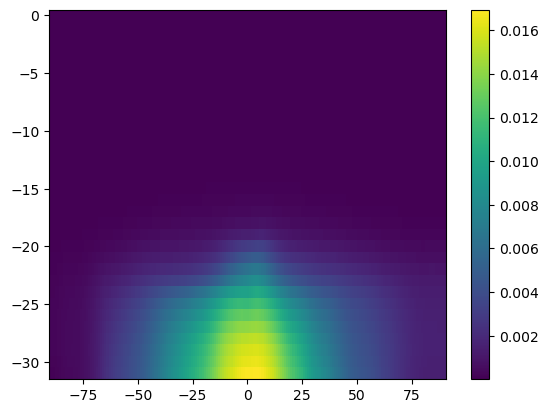

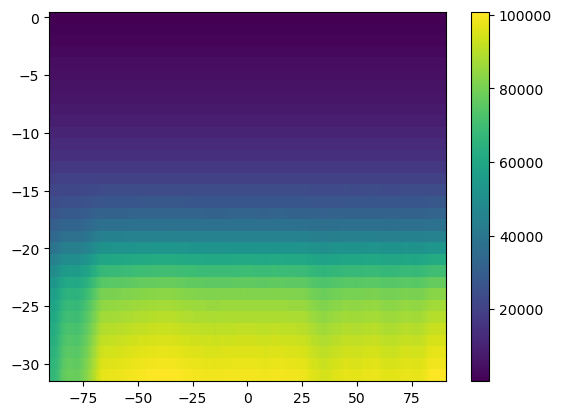

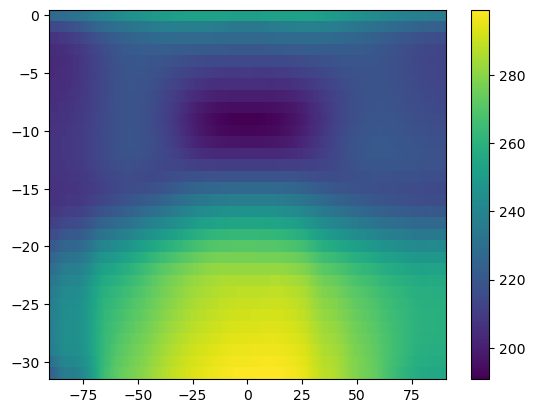

In [3]:
#get pressure/lat dimensions 
d1= np.size(PS_netCDF.hyam)
d2= np.size(PS_netCDF.lat) #size because they are 1-d
print(f'{d1} {d2}')

#calculate real pressure

P=PS_netCDF.hyam*PS_netCDF.P0+PS_netCDF.hybm*PS_netCDF.PS

#pressure sanity check
plt.pcolor(PS_netCDF.lat,-np.arange(32),Q_netCDF.Q)
plt.colorbar()

np.float64

plt.show()

plt.pcolor(PS_netCDF.lat,-np.arange(32),P)
plt.colorbar()

plt.show()

plt.pcolor(PS_netCDF.lat,-np.arange(32),T_netCDF.T)
plt.colorbar()

PyRADS stuff -- note that it asks for an RH and a stratospheric temperature, but I'm not sure they're needed. You may want to double-check this

In [4]:
from __future__ import division, print_function
import sys,os

sys.path.append("..")
import pyrads

from scipy.integrate import trapz,simps,cumtrapz

### -----------------------------------
### Helpers
class Dummy:
    pass


### -----------------------------------

# ---
## setup thermodynamic parameters
params = Dummy()

params.Rv = pyrads.phys.H2O.R # moist component
params.cpv = pyrads.phys.H2O.cp
params.Lvap = pyrads.phys.H2O.L_vaporization_TriplePoint
params.satvap_T0 = pyrads.phys.H2O.TriplePointT
params.satvap_e0 = pyrads.phys.H2O.TriplePointP
params.esat = lambda T: pyrads.Thermodynamics.get_satvps(T,params.satvap_T0,params.satvap_e0,params.Rv,params.Lvap)

params.R = pyrads.phys.air.R  # dry component
params.cp = pyrads.phys.air.cp
params.ps_dry = 1e5           # surface pressure of dry component

params.g = 9.8             # surface gravity
params.cosThetaBar = 3./5. # average zenith angle used in 2stream eqns

params.R_CO2 = pyrads.phys.CO2.R

# ---
## setup resolution (vertical,spectral)

wavenr_min = 0.1   # [cm^-1]
wavenr_max = 3500. #
#dwavenr = 0.01     #
dwavenr = 0.1     #

params.RH = .7            # relative humidity -- let's come back to this


Neither numpy nor Numeric found.
Please install numpy (preferred) or Numeric.


In [5]:
toa_flux = np.zeros((2,d2)) #array for storing toa fluxes

In [7]:
co2 = [360e-6, 720e-6]

# setup constants
g = Dummy()
g.Np = d1 #number of pressure levels
g.n0, g.n1, g.dn = wavenr_min, wavenr_max, dwavenr

# setup arrays
g.n = np.arange( g.n0, g.n1, g.dn )  # 1d
g.wave = np.tile( g.n,(g.Np,1) )         # 2d
g.Nn = len(g.n)

g.p = P[::-1] #make sure pressure is in Pa. Also, indexing convention is 0 = TOA, n = surface 

#Loop through all latitudes, both CO2 concentrations
for i in range( 2):
    params.ppv_CO2 = co2[i]    # CO2 concentration
    for j in tqdm(range(int(d2/2), d2)):
            #get surfce values
            g.Ts = np.array(TS_netCDF.TS[j])
            g.ps = np.array(PS_netCDF.PS[j])

            g.T = np.array(T_netCDF.T[::-1, j]) #again, be careful with indexing
            g.q = np.array(Q_netCDF.Q[::-1, j])
            g.p = np.array(P[::-1,j])
            
            g.tau, g.tau_h2o, g.tau_co2 = pyrads.OpticalThickness.compute_tau_H2ON2_CO2dilute(g.p,g.T,g.q,params.ppv_CO2,g,params, RH=params.RH )

            # compute Planck functions etc:
            #   -> here: fully spectrally resolved!
            T_2D = np.tile( g.T, (g.Nn,1) ).T               # [press x wave]
            g.B_surf = np.pi* pyrads.Planck.Planck_n( g.n,g.Ts )     # [wave]
            g.B = np.pi* pyrads.Planck.Planck_n( g.wave, T_2D )    # [press x wave]

            #The following calculates the fluxes at every height, 
            #but I think we can get away with just upwards at TOA
            """
            F = np.zeros( N_press)
            for k in range( N_press ):
                # compute OLR etc:
                olr_spec = pyrads.Get_Fluxes.Fplus_alternative(k,g) # (spectrally resolved=irradiance)
                down_spec = pyrads.Get_Fluxes.Fminus_alternative(k,g) # (spectrally resolved=irradiance)
                F[k] = simps(olr_spec,g.n) - simps(down_spec, g.n)
            """
            print(pyrads.Get_Fluxes.Fplus_alternative(0,g))
            toa_flux[i, j] = pyrads.Get_Fluxes.Fplus_alternative(0,g)

  0%|                                                    | 0/96 [00:00<?, ?it/s]

compute kappa at p,T =  99174.76271664351 298.45013
compute kappa at p,T =  97553.17802728014 297.42465
compute kappa at p,T =  95671.06725461781 296.00406
compute kappa at p,T =  93544.4856192614 294.43915
compute kappa at p,T =  91191.45337665593 292.88135
compute kappa at p,T =  88631.58331137942 291.42273
compute kappa at p,T =  85885.78073076019 290.13818
compute kappa at p,T =  82022.00451814756 288.47125
compute kappa at p,T =  76282.35511601577 285.8059
compute kappa at p,T =  69088.0439726687 281.47986
compute kappa at p,T =  60935.12291826471 276.4162
compute kappa at p,T =  52434.47111835517 270.44702
compute kappa at p,T =  44572.87224698323 262.99362
compute kappa at p,T =  37890.3873610663 254.56317
compute kappa at p,T =  32210.16713347833 245.52382
compute kappa at p,T =  27381.886603024264 236.34357
compute kappa at p,T =  23277.770725836133 227.25975
compute kappa at p,T =  19789.20588339088 218.49684
compute kappa at p,T =  16822.507977485657 210.2535
compute kappa a

/Users/samschulz/anaconda3/lib/python3.8/site-packages/pyrads/Planck.py:12: RuntimeWarning: invalid value encountered in divide
  return 2.*(phys.k*T)**3/((phys.h*phys.c)**2) * u**3/(np.exp(u)-1.)
  0%|                                                    | 0/96 [00:54<?, ?it/s]

done! 

[nan nan nan ... nan nan nan]


ValueError: setting an array element with a sequence.